In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import glob
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import time
from scipy import interpolate
import seaborn as sns

from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import cm

from matplotlib.patches import Rectangle, Polygon, Ellipse

In [2]:
#Set latex environment for plots/labels
# matplotlib.rc('font', **{'family': 'serif'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams.update({'font.family':'serif'})


fl=22
fm=18
fs=16

# sns.set_style("white")

/var/folders/wj/l7fs8hg555n8nzz7myk9cysw0000gn/T/ipykernel_50870/1261850473.py:4: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']


In [3]:
from natal_kick_tools import mandel_muller_likelihood_functions as mmf
from natal_kick_tools import likelihood_plot_functions as lpf

In [4]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = fm, second=False, labelpad=None, setMinor=True):
    plt.rcParams.update({'font.family':'serif'})

    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [5]:
# Define the models of interest
bh_kicks=[200]
# ns_kicks = [300, 350, 400, 450, 500, 550, 600, 650, 700]
ns_kicks = [400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700]

sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]

# Define the location of the posterior data
pulsar_data_loc = "../correctedPulsarPosteriors/correctedVtData"

# Read Velocity Data

## Model Velocities

In [6]:
# Define a dictionary to map v_ns and sigma to their arrays
kick_models = {}
sig = len(sigmas)
vns = len(ns_kicks)

for i in range(len(ns_kicks)):
    kick_models[f"NS_{ns_kicks[i]}_RANGE"] = np.arange(i*sig, (i*sig)+sig, 1)

for i in range(len(sigmas)):
    kick_models[f"SIGMA_{sigmas[i]}_RANGE"] = np.arange(i, (vns*sig) + i, sig)

kick_models["ALL"] = np.arange(0, vns*sig, 1)

In [7]:
# Read model velocity data (takes ~3 min)

start = time.time()

NS_KICKS_3D = []
NS_KICKS_2D = []
NS_KICK_MULT = [] 
SIGMAS = []

f = IntProgress(min=0, max=sig*vns) # instantiate the bar
display(f) # display the bar

for ns_kick in ns_kicks:
    for sigma in sigmas:
        f.value +=1
        fname = f"model_velocities/vns_{ns_kick}_sigma_{sigma}_velocities"
        v_3d, v_2d = np.loadtxt(fname, skiprows=1, unpack=True)
        NS_KICKS_3D.append(v_3d)
        NS_KICKS_2D.append(v_2d)
        NS_KICK_MULT.append(ns_kick)
        SIGMAS.append(sigma)    
        
end = time.time()
print(end - start, "s")

IntProgress(value=0, max=65)

77.07437586784363 s


In [8]:
def plot_kde(PLOT_RANGE, NS_KICKS_3D, NS_KICKS_2D, d=3, output=None, lw=3, linestyle='-', alpha=1, label_prefix='', label_suffix=''):    
    for i in PLOT_RANGE:
        kde_NS_3D = gaussian_kde( NS_KICKS_3D[i] )
        kde_NS_2D = gaussian_kde( NS_KICKS_2D[i] )
        NS_dist_space = linspace( min(NS_KICKS_3D[i]), max(NS_KICKS_3D[i]), 300 )
        label_str = label_prefix + r'v$_{ns}$=' + '{nskick}'.format(nskick=NS_KICK_MULT[i]) + ', $\sigma_{ns}$=' + '{sig}'.format(sig=SIGMAS[i]) + label_suffix
        if d==2:
            plt.plot( NS_dist_space, kde_NS_2D(NS_dist_space), linestyle, lw=lw, label=label_str, alpha=alpha);
        else:
            plt.plot( NS_dist_space, kde_NS_3D(NS_dist_space), linestyle, lw=lw, label=label_str, alpha=alpha);

    layoutAxes(ax=ax, nameX='NS Velocity [km/s]',\
               nameY='Velocity Distribution [(km/s)$^{-1}$]')

    plt.rc('font', size=fm)
    plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0), useMathText=True)

    plt.xlim(0, 1200)

    plt.legend(fontsize=fm)
    plt.tight_layout()
    if output is not None:
        plt.savefig(output)
        

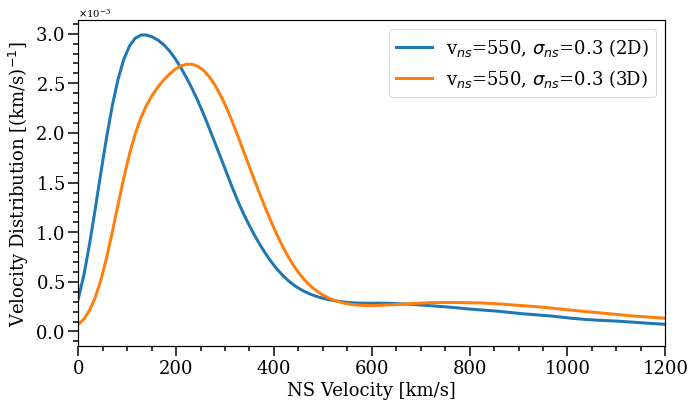

In [9]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
plt.rcParams.update({'font.family':'serif'})
plot_kde(np.intersect1d(kick_models["NS_550_RANGE"], kick_models["SIGMA_0.3_RANGE"]), NS_KICKS_3D, NS_KICKS_2D, label_suffix=' (2D)', d=2)
plot_kde(np.intersect1d(kick_models["NS_550_RANGE"], kick_models["SIGMA_0.3_RANGE"]), NS_KICKS_3D, NS_KICKS_2D, label_suffix=' (3D)', d=3)
plt.show()

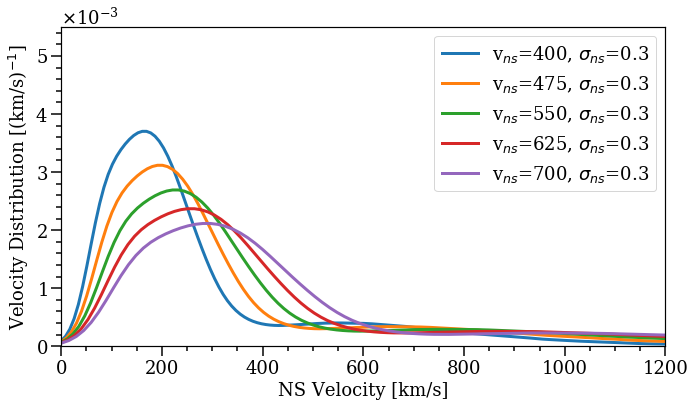

In [12]:
output=None

f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
ax.set_ylim(0, 5.5e-3)
plot_kde(kick_models["SIGMA_0.3_RANGE"][::3], NS_KICKS_3D, NS_KICKS_2D, output=output)

## Paper plots

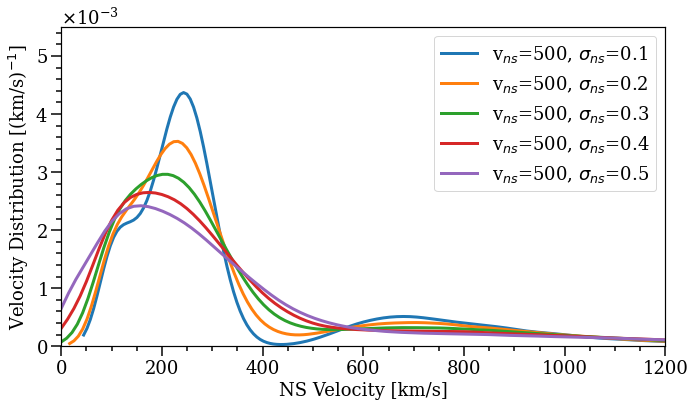

In [26]:
output=None
output='plots/ns_kicks_500_range_sse.pdf'

f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
ax.set_ylim(0, 5.5e-3)
plot_kde(kick_models["NS_500_RANGE"], NS_KICKS_3D, NS_KICKS_2D, output=output)

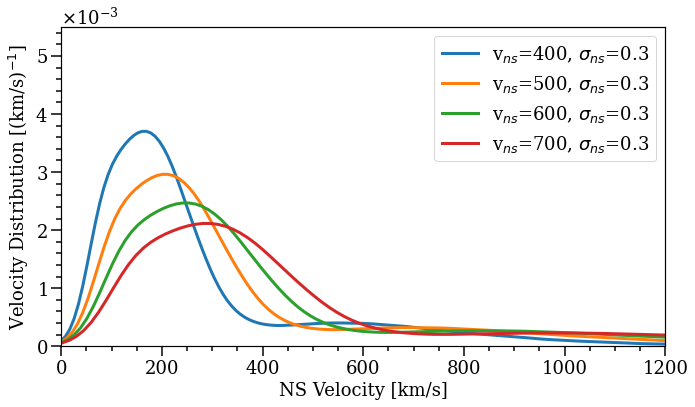

In [15]:
output=None
# output='plots/sigma_0.3_range_sse.pdf'

f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
ax.set_ylim(0, 5.5e-3)
plot_kde(kick_models["SIGMA_0.3_RANGE"][::4], NS_KICKS_3D, NS_KICKS_2D, output=output)

# Read Likelihood Data

In [13]:
p_models = []
columns = [] # labels for plotting model likelihoods in next cell
for ns_kick in ns_kicks:
    for sigma in sigmas:
        fname = f"calculatedModelLikelihoods/vns_{ns_kick}_sigma_{sigma}"
        all_likelihoods = np.loadtxt(fname)
        p_models.append(np.prod(all_likelihoods))
        
        col_name = f"vns_{ns_kick}_sigma_{sigma}"
        columns.append(col_name)
        
# normalize the array
p_models = p_models/np.max(p_models)


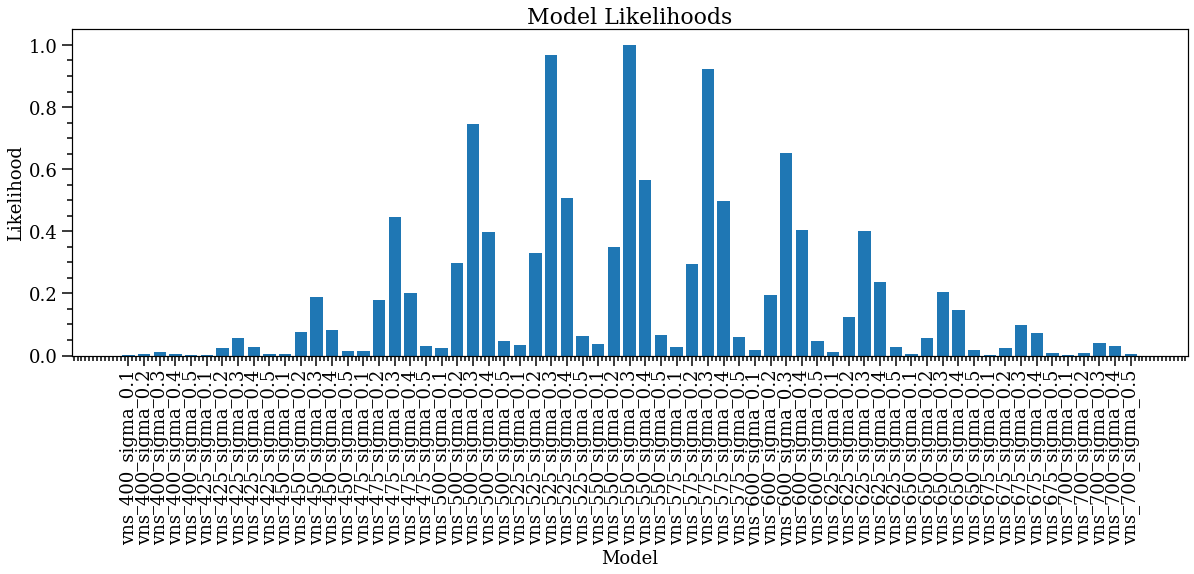

In [14]:
f, ax= plt.subplots(1, 1,  figsize=(20,6)) 

x_range = np.linspace(0, len(p_models), len(p_models))
plt.bar(x_range, p_models, tick_label=columns)

layoutAxes(ax=ax, nameX='Model',\
           nameY='Likelihood')
plt.xticks(rotation=90)
# plt.semilogy()

plt.title("Model Likelihoods", fontsize=fl)

plt.show()

## 2D Plot

In [15]:
p_models_2d = p_models.reshape([len(ns_kicks), len(sigmas)])
max_num = len(p_models) # number of max likelihoods to label

# Some code to generate labels for only the top n models
M = sorted(zip(p_models), reverse=True)[max_num - 1][0]
label_f  = np.vectorize(lambda v: f"{v:.3f}" if v >= M else '')
labels = label_f(p_models_2d)

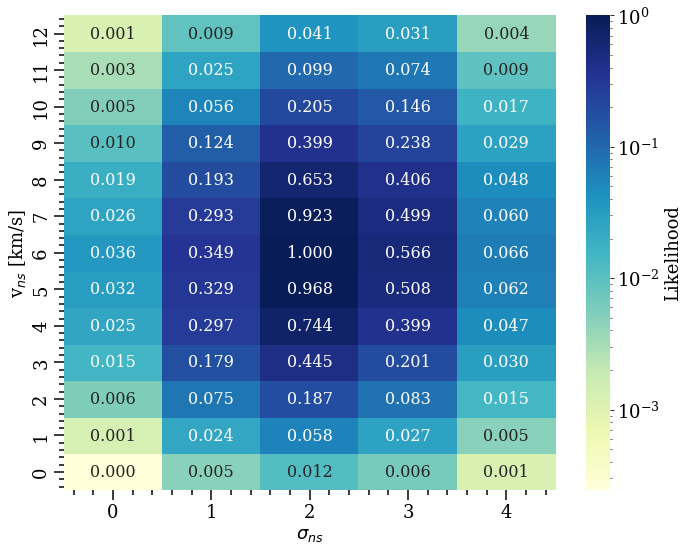

In [16]:
f, ax= plt.subplots(1, 1,  figsize=(10,8)) 

ax = sns.heatmap(p_models_2d,  cmap="YlGnBu", linewidth=0, norm=LogNorm(),\
                 annot=labels, annot_kws={'fontsize':fs}, fmt="", cbar_kws={'label': 'Likelihood'})


layoutAxes(ax=ax, fontsize=fm)

plt.xlabel('$\sigma_{ns}$', fontsize=fm)
plt.ylabel('v$_{ns}$ [km/s]', fontsize=fm)

ax.figure.axes[-1].yaxis.label.set_size(fm)
ax.figure.axes[-1].tick_params(labelsize=fm)


plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()


# 2D Gaussian Fit

In [17]:
def twoD_Gaussian(coords, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x = coords[0]
    y = coords[1]
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [18]:
# Create x and y indices
x = sigmas
y = ns_kicks
x, y = np.meshgrid(x, y)

#create data
data = p_models

In [19]:
from scipy import optimize as opt

# try to fit the data using a 2d gaussian
initial_guess = (1,0.3,550,0.05,10,0)

popt, pcov = opt.curve_fit(twoD_Gaussian, [x, y], data, p0=initial_guess)

X_mu_fit = popt[1]
Y_mu_fit = popt[2]

X_sigma_fit = popt[3]
Y_sigma_fit = popt[4]

theta_fit = popt[5]

In [20]:
print(f"Best fit v_ns mu: {Y_mu_fit}")
print(f"Best fit v_ns std: {Y_sigma_fit}")
print(f"Best fit sigma mu: {X_mu_fit}")
print(f"Best fit sigma std: {X_sigma_fit}")

Best fit v_ns mu: 548.2957268442393
Best fit v_ns std: 55.94314234944461
Best fit sigma mu: 0.31422205989450486
Best fit sigma std: 0.07768801486414259


## 90% Confidence Interval

In [21]:
print(f"90% confidence interval for v_ns: {Y_mu_fit:.2f} ± {2*Y_sigma_fit:.2f}")
print(f"90% confidence interval for sigma_ns: {X_mu_fit:.2f} ± {2*X_sigma_fit:.2f}")

90% confidence interval for v_ns: 548.30 ± 111.89
90% confidence interval for sigma_ns: 0.31 ± 0.16


In [22]:
import math
 
# Function to check if the point (x,y) is within ellipse centered at (h,k) with semi-maj axes (a,b), 
# rotated by angle
def check_point(x, y, h, k, a, b, angle):

    cos_angle = np.cos(np.radians(180.-angle))
    sin_angle = np.sin(np.radians(180.-angle))

    xc = x - h
    yc = y - k

    xct = xc * cos_angle - yc * sin_angle
    yct = xc * sin_angle + yc * cos_angle 

    rad_cc = (xct**2/(a)**2) + (yct**2/(b)**2)
 
    return rad_cc <= 1

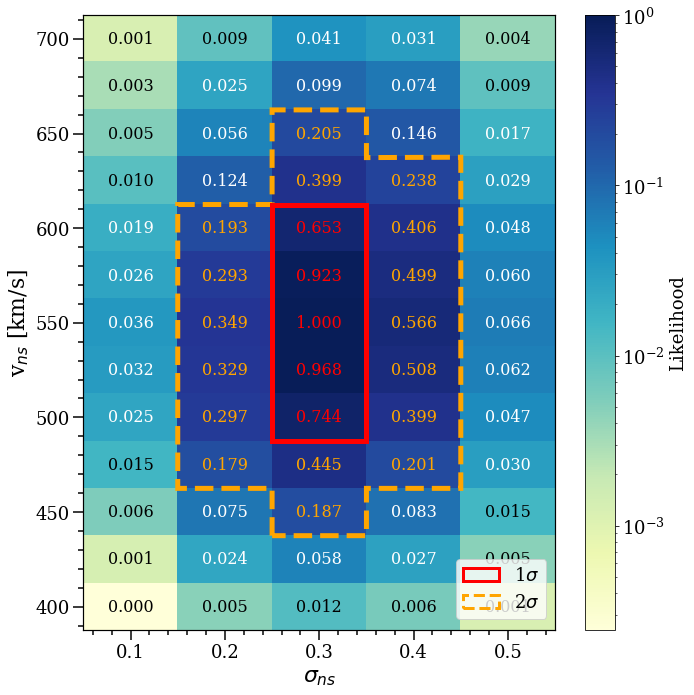

In [38]:
fig, ax = plt.subplots(1, 1,  figsize=(10,10)) 

dX = 0.05
dY = 12.5


# PLOT LIKELIHOOD GRID
im = plt.imshow(data.reshape(len(ns_kicks), len(sigmas)), aspect='auto', cmap=cm.YlGnBu, interpolation=None , \
           extent=[min(sigmas)-dX, max(sigmas)+dX, max(ns_kicks)+dY, min(ns_kicks)-dY], norm=LogNorm(vmin=min(p_models), vmax=max(p_models)))
cbar = plt.colorbar(label="Likelihood")




# PLOT LABELS
valfmt = matplotlib.ticker.StrMethodFormatter("{x:.3f}")
textcolors = ["black", "white"]
threshold = im.norm(p_models_2d.max())/2.

for i, kick in enumerate(ns_kicks):
    for j, sig in enumerate (sigmas):
        
        # black or white color based on cell lightness
        color=textcolors[int(im.norm(p_models_2d[i, j]) > threshold)]
        
        # 2 sigma models
        if check_point(sig, kick, X_mu_fit, Y_mu_fit, 2*X_sigma_fit, 2*Y_sigma_fit, theta_fit):
            color='orange'
            
        # 1 sigma models
        if check_point(sig, kick, X_mu_fit, Y_mu_fit, X_sigma_fit, Y_sigma_fit, theta_fit):
            color='r'
       
        text = ax.text(sig, kick, valfmt(p_models_2d[i, j]),
                       ha="center", va="center", color=color, fontsize=fs, zorder=3)

# PLOT CONTOURS
lw = 5
alpha=0.7

# # 1 sigma contour
# ax.add_patch(Ellipse((X_mu_fit, Y_mu_fit), width=2*X_sigma_fit, height=2*Y_sigma_fit, angle=theta_fit,
#                      color='r', linewidth=lw, linestyle='--', alpha=alpha, fill=False, zorder=2, label= '1$\sigma$'))

# # 2 sigma contour
# ax.add_patch(Ellipse((X_mu_fit, Y_mu_fit), width=2*2*X_sigma_fit, height=2*2*Y_sigma_fit, angle=theta_fit,
#                      color='orange', linewidth=lw, linestyle='--', alpha=alpha, fill=False, zorder=2, label= '2$\sigma$'))

ax.add_patch(Rectangle((0.25,487.5), 0.1, 125, fill=False, edgecolor='r', hatch='',  lw=lw, linestyle='-', clip_on=False, label= '1$\sigma$', zorder=2))

ax.add_patch(Polygon(((0.25, 437.5), (0.25, 462.5), (0.15, 462.5), \
                      (0.15, 612.5), (0.25, 612.5), \
                      (0.25, 662.5), (0.35, 662.5), \
                      (0.35, 637.3), (0.45, 637.5), \
                      (0.45, 462.5), (0.35, 462.5), (0.35, 437.5)), fill=False, edgecolor='orange', hatch='', lw=lw, linestyle='--', clip_on=False, label='2$\sigma$',zorder=1))





# # PLOT BEST-FIT POINT
# lww = 3
# cww = 'r'
# plt.axhline(y=Y_mu_fit, color=cww, alpha=alpha, linewidth=lww, linestyle='-')
# plt.axvline(x=X_mu_fit, color=cww, alpha=alpha, linewidth=lww, linestyle='-')



# HOUSEKEEPING
layoutAxes(ax=ax, fontsize=fm)

plt.xlabel('$\sigma_{ns}$', fontsize=fl)
plt.ylabel('v$_{ns}$ [km/s]', fontsize=fl)

ax.figure.axes[-1].yaxis.label.set_size(fm)
ax.figure.axes[-1].tick_params(labelsize=fm)

handles, labels = plt.gca().get_legend_handles_labels()
  
# specify order
order = [1,0]
  
# pass handle & labels lists along with order as below
plt.legend([handles[i] for i in order], [labels[i] for i in order])

leg = ax.legend(bbox_to_anchor=(1.0, 0.13), fontsize=fm)

# change the line width for the legend
for patch in leg.get_patches():
    patch.set_linewidth(3.0)
    patch.set_alpha(1.0)
    
plt.gca().invert_yaxis()
plt.tight_layout()

# plt.savefig('plots/model_likelihoods_2d_sse.pdf') 

plt.show()